# Amino acid preferences
This notebook takes codon counts and uses dms_tools2 to calculate the amino acid preferences at mutagenezed sites in the Zika Virus NS5 protein.

## Notebook setup
Imports

In [1]:
import dms_tools2
import numpy as np
import os
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO
from dms_tools2.ipython_utils import showPDF

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

dms_tools2==2.6.8
numpy==1.19.1
pandas==0.25.3
plotnine==0.6.0
regex==2.5.83


Input data

In [2]:
samplesheet = 'data/samplesheet.csv'
codon_counts_dir = 'results/codon_counts/'

Output data

In [3]:
results_dir = 'results/'

Analysis parameters

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

## Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
samples = samples.drop('r1_file', axis=1)
samples.insert(0, 'name', (samples['library'] + '-' +
                           samples['source'] + '-' +
                           samples['stage'] + '-' +
                           samples['sorted']))
display(samples)

,name,library,source,stage,sorted
0,wt-plasmid-noStage-notSorted,wt,plasmid,noStage,notSorted
1,wt-gDNA-noStage-notSorted,wt,gDNA,noStage,notSorted
2,lib1-plasmid-noStage-notSorted,lib1,plasmid,noStage,notSorted
3,lib2-plasmid-noStage-notSorted,lib2,plasmid,noStage,notSorted
4,lib3-plasmid-noStage-notSorted,lib3,plasmid,noStage,notSorted
5,lib1-gDNA-early-notSorted,lib1,gDNA,early,notSorted
6,lib2-gDNA-early-notSorted,lib2,gDNA,early,notSorted
7,lib3-gDNA-early-notSorted,lib3,gDNA,early,notSorted
8,lib1-gDNA-mid-notSorted,lib1,gDNA,mid,notSorted
9,lib2-gDNA-mid-notSorted,lib2,gDNA,mid,notSorted


# Calculate amino acid preferences
Calculate the [amino acid preferences](https://jbloomlab.github.io/dms_tools2/prefs.html) of the sites on each mutagenized gDNA sample.

Setup:

In [6]:
# Set up results dir
prefs_dir = os.path.join(results_dir + 'prefs')
os.makedirs(prefs_dir, exist_ok=True)

# Params
ncpus = 16
use_existing = 'no'

# Workg with each group so correlations can be viewed
samples_iter = (samples
                .query('library != "wt"')
                .query('source != "plasmid"'))
for stage in samples_iter['stage'].unique():
    for sort_status in samples_iter.query(f'stage == "{stage}"')['sorted'].unique():
        # Make samplesheet
        batchfile = os.path.join(prefs_dir + '/' + f'{stage}_{sort_status}' + '_batchfile.csv')
        # Code from Jesse to quickly automatically generate this.
        batchfile_df = (
            samples
            .query(f'stage == "{stage}" and sorted == "{sort_status}"')
            .query('library != "wt"')
            .query('source != "plasmid"')
            .assign(post=lambda x: x['name'])
            .merge(samples.query('source == "plasmid"')
                          .assign(pre=lambda x: x['name'])
                          [['library', 'pre']],
                   on=['library'], how='left', validate='many_to_one',
                   )
            [['name', 'source', 'library', 'stage', 'sorted', 'pre', 'post',]]
            .assign(errpre='wt-plasmid-noStage-notSorted')
            .merge(samples.query('library == "wt"')
                          .assign(errpost=lambda x: x['name'])
                          [['source', 'errpost']],
                   on=['source'], how='left'
                   )
            )
        assert batchfile_df.notnull().all().all()
        display(batchfile_df)

        print(f'Writing batchfile to {batchfile}')
        batchfile_df.to_csv(batchfile, index=False)
        print('Done.')
        
        # Run batch_prefs
        log = ! dms2_batch_prefs \
                --batchfile {batchfile} \
                --summaryprefix {stage}-{sort_status}-summary \
                --method ratio \
                --indir {codon_counts_dir} \
                --outdir {prefs_dir} \
                --ncpus {ncpus} \
                --use_existing {use_existing} \
                --excludestop 'no'

        print(log)

        print(f"Amino-acid preferences calculated for {stage} {sort_status} samples.")


,name,source,library,stage,sorted,pre,post,errpre,errpost
0,lib1-gDNA-early-notSorted,gDNA,lib1,early,notSorted,lib1-plasmid-noStage-notSorted,lib1-gDNA-early-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
1,lib2-gDNA-early-notSorted,gDNA,lib2,early,notSorted,lib2-plasmid-noStage-notSorted,lib2-gDNA-early-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
2,lib3-gDNA-early-notSorted,gDNA,lib3,early,notSorted,lib3-plasmid-noStage-notSorted,lib3-gDNA-early-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted


Writing batchfile to results/prefs/early_notSorted_batchfile.csv
Done.
['INFO:dms2_batch_prefs:Beginning execution of dms2_batch_prefs in directory /fh/fast/bloom_j/computational_notebooks/dbacsik/2022/ns5_small_mutagenesis', '', 'INFO:dms2_batch_prefs:Progress is being logged to results/prefs/early-notSorted-summary.log', 'INFO:dms2_batch_prefs:Version information:', '\tTime and date: Tue Jan 25 09:48:18 2022', '\tPlatform: Linux-4.15.0-88-generic-x86_64-with-debian-buster-sid', '\tPython version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08)  [GCC 7.5.0]', '\tdms_tools2 version: 2.6.8', '\tBio version: 1.77', '\tpandas version: 0.25.3', '\tnumpy version: 1.19.1', '\tIPython version: 7.18.1', '\tjupyter version: 1.0.0', '\tmatplotlib version: 3.2.2', '\tplotnine version: 0.6.0', '\tnatsort version: 7.0.1', '\tpystan version: 2.19.1.1', '\tscipy version: 1.5.2', '\tseaborn version: 0.10.1', '\tphydmslib version: 2.4.1', '\tstatsmodels version: 0.12.0', '\trpy2 cann

,name,source,library,stage,sorted,pre,post,errpre,errpost
0,lib1-gDNA-mid-notSorted,gDNA,lib1,mid,notSorted,lib1-plasmid-noStage-notSorted,lib1-gDNA-mid-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
1,lib2-gDNA-mid-notSorted,gDNA,lib2,mid,notSorted,lib2-plasmid-noStage-notSorted,lib2-gDNA-mid-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
2,lib3-gDNA-mid-notSorted,gDNA,lib3,mid,notSorted,lib3-plasmid-noStage-notSorted,lib3-gDNA-mid-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted


Writing batchfile to results/prefs/mid_notSorted_batchfile.csv
Done.
['INFO:dms2_batch_prefs:Beginning execution of dms2_batch_prefs in directory /fh/fast/bloom_j/computational_notebooks/dbacsik/2022/ns5_small_mutagenesis', '', 'INFO:dms2_batch_prefs:Progress is being logged to results/prefs/mid-notSorted-summary.log', 'INFO:dms2_batch_prefs:Version information:', '\tTime and date: Tue Jan 25 09:48:31 2022', '\tPlatform: Linux-4.15.0-88-generic-x86_64-with-debian-buster-sid', '\tPython version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08)  [GCC 7.5.0]', '\tdms_tools2 version: 2.6.8', '\tBio version: 1.77', '\tpandas version: 0.25.3', '\tnumpy version: 1.19.1', '\tIPython version: 7.18.1', '\tjupyter version: 1.0.0', '\tmatplotlib version: 3.2.2', '\tplotnine version: 0.6.0', '\tnatsort version: 7.0.1', '\tpystan version: 2.19.1.1', '\tscipy version: 1.5.2', '\tseaborn version: 0.10.1', '\tphydmslib version: 2.4.1', '\tstatsmodels version: 0.12.0', '\trpy2 cannot b

,name,source,library,stage,sorted,pre,post,errpre,errpost
0,lib1-gDNA-late-notSorted,gDNA,lib1,late,notSorted,lib1-plasmid-noStage-notSorted,lib1-gDNA-late-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
1,lib2-gDNA-late-notSorted,gDNA,lib2,late,notSorted,lib2-plasmid-noStage-notSorted,lib2-gDNA-late-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
2,lib3-gDNA-late-notSorted,gDNA,lib3,late,notSorted,lib3-plasmid-noStage-notSorted,lib3-gDNA-late-notSorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted


Writing batchfile to results/prefs/late_notSorted_batchfile.csv
Done.
['INFO:dms2_batch_prefs:Beginning execution of dms2_batch_prefs in directory /fh/fast/bloom_j/computational_notebooks/dbacsik/2022/ns5_small_mutagenesis', '', 'INFO:dms2_batch_prefs:Progress is being logged to results/prefs/late-notSorted-summary.log', 'INFO:dms2_batch_prefs:Version information:', '\tTime and date: Tue Jan 25 09:48:43 2022', '\tPlatform: Linux-4.15.0-88-generic-x86_64-with-debian-buster-sid', '\tPython version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08)  [GCC 7.5.0]', '\tdms_tools2 version: 2.6.8', '\tBio version: 1.77', '\tpandas version: 0.25.3', '\tnumpy version: 1.19.1', '\tIPython version: 7.18.1', '\tjupyter version: 1.0.0', '\tmatplotlib version: 3.2.2', '\tplotnine version: 0.6.0', '\tnatsort version: 7.0.1', '\tpystan version: 2.19.1.1', '\tscipy version: 1.5.2', '\tseaborn version: 0.10.1', '\tphydmslib version: 2.4.1', '\tstatsmodels version: 0.12.0', '\trpy2 cannot

,name,source,library,stage,sorted,pre,post,errpre,errpost
0,lib1-gDNA-late-sorted,gDNA,lib1,late,sorted,lib1-plasmid-noStage-notSorted,lib1-gDNA-late-sorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
1,lib2-gDNA-late-sorted,gDNA,lib2,late,sorted,lib2-plasmid-noStage-notSorted,lib2-gDNA-late-sorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted
2,lib3-gDNA-late-sorted,gDNA,lib3,late,sorted,lib3-plasmid-noStage-notSorted,lib3-gDNA-late-sorted,wt-plasmid-noStage-notSorted,wt-gDNA-noStage-notSorted


Writing batchfile to results/prefs/late_sorted_batchfile.csv
Done.
['INFO:dms2_batch_prefs:Beginning execution of dms2_batch_prefs in directory /fh/fast/bloom_j/computational_notebooks/dbacsik/2022/ns5_small_mutagenesis', '', 'INFO:dms2_batch_prefs:Progress is being logged to results/prefs/late-sorted-summary.log', 'INFO:dms2_batch_prefs:Version information:', '\tTime and date: Tue Jan 25 09:48:55 2022', '\tPlatform: Linux-4.15.0-88-generic-x86_64-with-debian-buster-sid', '\tPython version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08)  [GCC 7.5.0]', '\tdms_tools2 version: 2.6.8', '\tBio version: 1.77', '\tpandas version: 0.25.3', '\tnumpy version: 1.19.1', '\tIPython version: 7.18.1', '\tjupyter version: 1.0.0', '\tmatplotlib version: 3.2.2', '\tplotnine version: 0.6.0', '\tnatsort version: 7.0.1', '\tpystan version: 2.19.1.1', '\tscipy version: 1.5.2', '\tseaborn version: 0.10.1', '\tphydmslib version: 2.4.1', '\tstatsmodels version: 0.12.0', '\trpy2 cannot be im

Show correlations:

Correlation of AA preferences

early notSorted


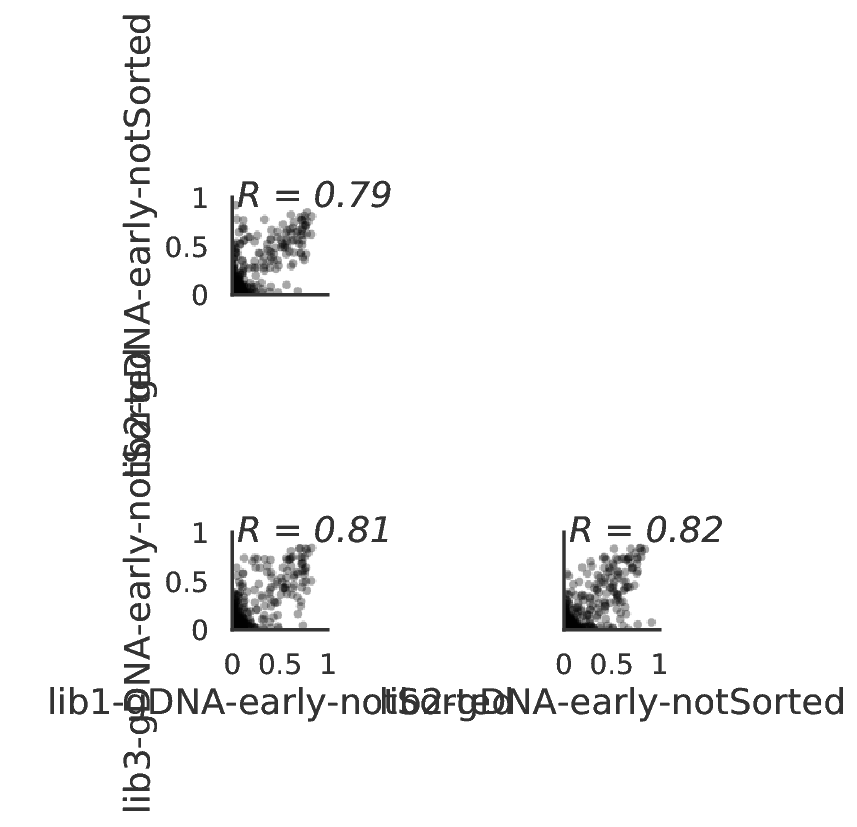

Correlation of AA preferences

mid notSorted


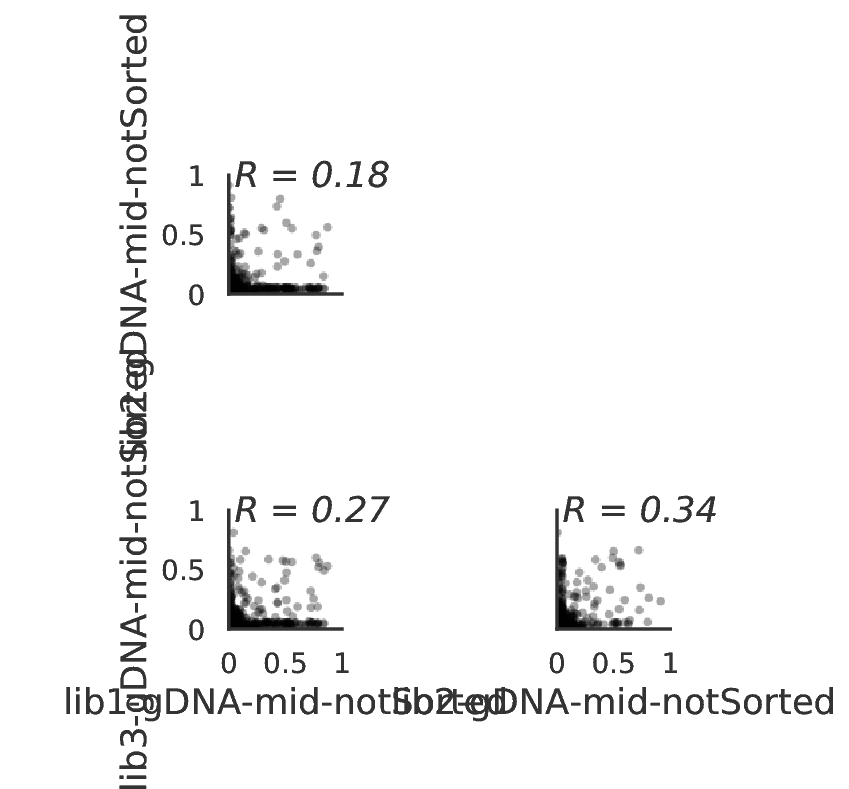

Correlation of AA preferences

late notSorted


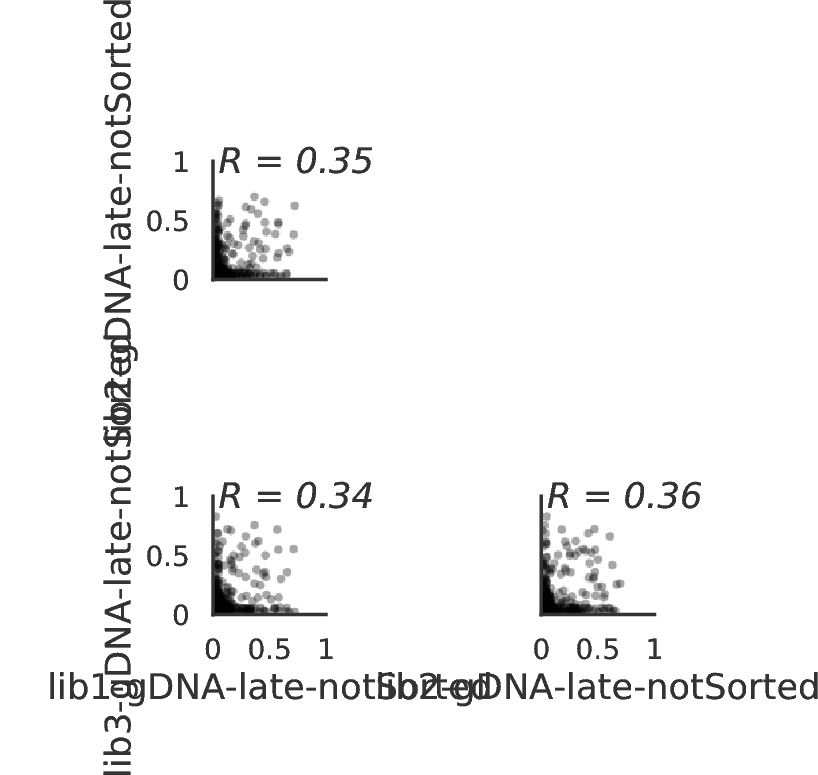

Correlation of AA preferences

late sorted


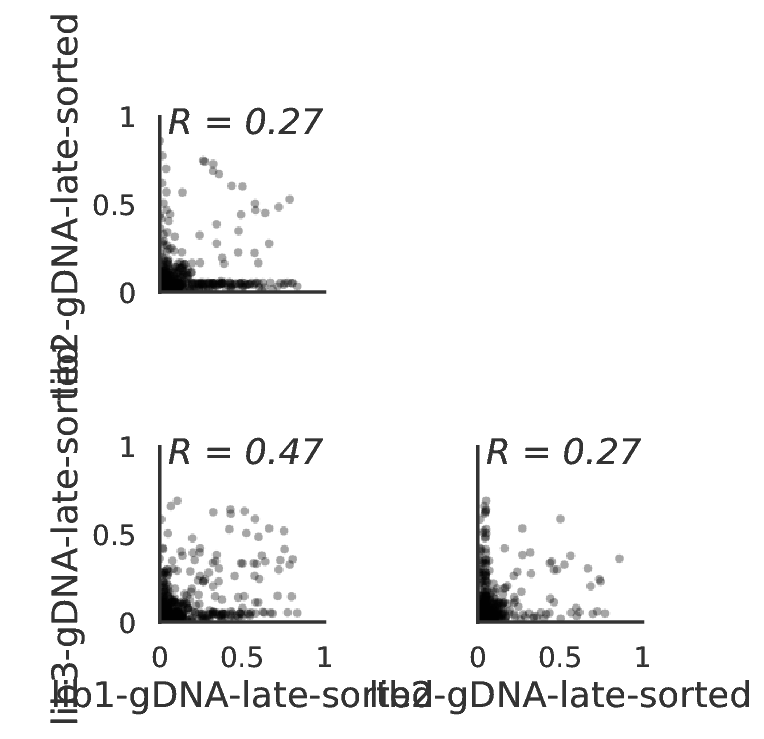

In [10]:
for stage in samples_iter['stage'].unique():
    for sort_status in samples_iter.query(f'stage == "{stage}"')['sorted'].unique():
        path = os.path.join(prefs_dir, f'{stage}-{sort_status}-summary_prefscorr.pdf')
        print('Correlation of AA preferences\n')
        print(stage, sort_status)
        showPDF(path)